# CKD Prediction - Model Training & Evaluation

Time to train some models! I'm testing 5 different algorithms using cross-validation to see which performs best.

**Models I'm comparing:**
- Logistic Regression (baseline)
- Decision Tree
- Random Forest
- Support Vector Machine (SVM)
- XGBoost

**What I'm looking for:**
- Sensitivity >95% (catching CKD cases is crucial)
- Specificity >90% (avoiding false alarms)
- AUC-ROC >0.95 (overall model quality)

I'm using 5-fold stratified cross-validation with pipelines to prevent data leakage.

## Importing Libraries

In [ ]:
# Data manipulation
import pandas as pd
import numpy as np
import json

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Preprocessing and pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate

# Evaluation metrics
from sklearn.metrics import make_scorer, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("✅ Libraries loaded!")

✅ All libraries imported successfully!


## Loading the Preprocessed Data

Bringing in the cleaned data from the first notebook.

In [ ]:
# Load preprocessed data
data_dir= '/Users/reembaraka/Documents/Boulder data science/DTSA 5506/Project/Data/Pre-Processed'

X = pd.read_csv(f'{data_dir}/X.csv')
y = pd.read_csv(f'{data_dir}/y.csv')['Class']

# Load categorical mappings for reference
with open(f'{data_dir}/categorical_mappings.json', 'r') as f:
    categorical_mappings = json.load(f)

## Setting Up Cross-Validation

Using 5-fold stratified cross-validation to:
- Keep class balance consistent across all folds
- Use all 400 patients for both training and testing
- Ensure reproducible results (random_state=42)

In [ ]:
# Initialize 5-fold stratified cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## Defining Evaluation Metrics

Here's what I'm tracking for each model:
- **Sensitivity (Recall):** Can we catch the CKD cases? Target >95%
- **Specificity:** Are we avoiding false positives? Target >90%
- **AUC-ROC:** Overall model performance. Target >0.95
- **Accuracy:** General correctness
- **Precision:** When we predict CKD, are we right?
- **F1-Score:** Balance between precision and recall

In [ ]:
# Custom specificity scorer (sklearn doesn't have this built-in)
def specificity_score(y_true, y_pred):
    # Specificity = TN / (TN + FP)
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    return tn / (tn + fp) if (tn + fp) > 0 else 0

# Create scoring dictionary for cross-validation
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'sensitivity': make_scorer(recall_score),  # Sensitivity = recall
    'specificity': make_scorer(specificity_score),
    'precision': make_scorer(precision_score),
    'f1_score': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score, needs_proba=True)
}

## Building the Models

Setting up pipelines for each model. Each pipeline includes StandardScaler + the classifier to prevent data leakage during cross-validation.

In [ ]:
# Initialize models with default parameters
models = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()), ('classifier', LogisticRegression(random_state=42, max_iter=1000))
    ]),

    'Random Forest': Pipeline([
        ('scaler', StandardScaler()), ('classifier', RandomForestClassifier(random_state=42, n_estimators=100))
    ]),

    'Decision Tree': Pipeline([
        ('scaler', StandardScaler()), ('classifier', DecisionTreeClassifier(random_state=42))
    ]),

    'SVM': Pipeline([
        ('scaler', StandardScaler()), ('classifier', SVC(random_state=42, probability=True))
    ]),
    
    'XGBoost': Pipeline([
        ('scaler', StandardScaler()), ('classifier', XGBClassifier(random_state=42, eval_metric='logloss'))
    ])
}

print("Models ready to train:")
for i, model_name in enumerate(models.keys(), 1):
    print(f"  {i}. {model_name}")

  1. Logistic Regression
  2. Random Forest
  3. Decision Tree
  4. SVM
  5. XGBoost


## Training All Models

Running 5-fold cross-validation for each model and collecting all the metrics.

In [20]:
# Train and evaluate all models
results = {}

for model_name, pipeline in models.items():
    cv_results = cross_validate(
        pipeline, X, y, 
        cv=skf,
        scoring=scoring,
        return_train_score=False,
        n_jobs=-1
    )
    
    results[model_name] = {
        'accuracy_mean': cv_results['test_accuracy'].mean(),
        'accuracy_std': cv_results['test_accuracy'].std(),
        'sensitivity_mean': cv_results['test_sensitivity'].mean(),
        'sensitivity_std': cv_results['test_sensitivity'].std(),
        'specificity_mean': cv_results['test_specificity'].mean(),
        'specificity_std': cv_results['test_specificity'].std(),
        'precision_mean': cv_results['test_precision'].mean(),
        'precision_std': cv_results['test_precision'].std(),
        'f1_mean': cv_results['test_f1_score'].mean(),
        'f1_std': cv_results['test_f1_score'].std(),
        'roc_auc_mean': cv_results['test_roc_auc'].mean(),
        'roc_auc_std': cv_results['test_roc_auc'].std()
    }

## Results Summary

Let's see how each model performed. The checkmarks show which models hit the target thresholds.

In [ ]:
# Display results with target indicators
results_table = []

for model_name, r in results.items():
    sens_check = '✅' if r['sensitivity_mean'] > 0.95 else '⚠️'
    spec_check = '✅' if r['specificity_mean'] > 0.90 else '⚠️'
    auc_check = '✅' if r['roc_auc_mean'] > 0.95 else '⚠️'
    
    results_table.append({
        'Model': model_name,
        'Accuracy': f"{r['accuracy_mean']:.4f} ± {r['accuracy_std']:.4f}",
        'Sensitivity': f"{r['sensitivity_mean']:.4f} ± {r['sensitivity_std']:.4f} {sens_check}",
        'Specificity': f"{r['specificity_mean']:.4f} ± {r['specificity_std']:.4f} {spec_check}",
        'Precision': f"{r['precision_mean']:.4f} ± {r['precision_std']:.4f}",
        'F1 Score': f"{r['f1_mean']:.4f} ± {r['f1_std']:.4f}",
        'ROC-AUC': f"{r['roc_auc_mean']:.4f} ± {r['roc_auc_std']:.4f} {auc_check}"
    })

results_df_display = pd.DataFrame(results_table)
print(results_df_display.to_string(index=False))

# Save detailed metrics table
results_df_display.to_csv(f'{results_dir}/detailed_model_metrics.csv', index=False)

              Model        Accuracy        Sensitivity       Specificity       Precision        F1 Score            ROC-AUC
Logistic Regression 0.9825 ± 0.0170  0.9867 ± 0.0163 ✅ 0.9800 ± 0.0219 ✅ 0.9683 ± 0.0342 0.9771 ± 0.0218  0.9992 ± 0.0010 ✅
      Random Forest 0.9800 ± 0.0127  0.9600 ± 0.0327 ✅ 0.9920 ± 0.0098 ✅ 0.9867 ± 0.0163 0.9728 ± 0.0177  0.9995 ± 0.0005 ✅
      Decision Tree 0.9500 ± 0.0137 0.9467 ± 0.0340 ⚠️ 0.9520 ± 0.0299 ✅ 0.9252 ± 0.0450 0.9344 ± 0.0169 0.9493 ± 0.0129 ⚠️
                SVM 0.9825 ± 0.0127  0.9800 ± 0.0163 ✅ 0.9840 ± 0.0150 ✅ 0.9740 ± 0.0242 0.9768 ± 0.0167  0.9993 ± 0.0006 ✅
            XGBoost 0.9825 ± 0.0170  0.9733 ± 0.0389 ✅ 0.9880 ± 0.0098 ✅ 0.9800 ± 0.0164 0.9763 ± 0.0235  0.9976 ± 0.0033 ✅


## ROC Curves Comparison

Visualizing model performance across all folds. The zoomed view shows performance in the critical high-sensitivity region.

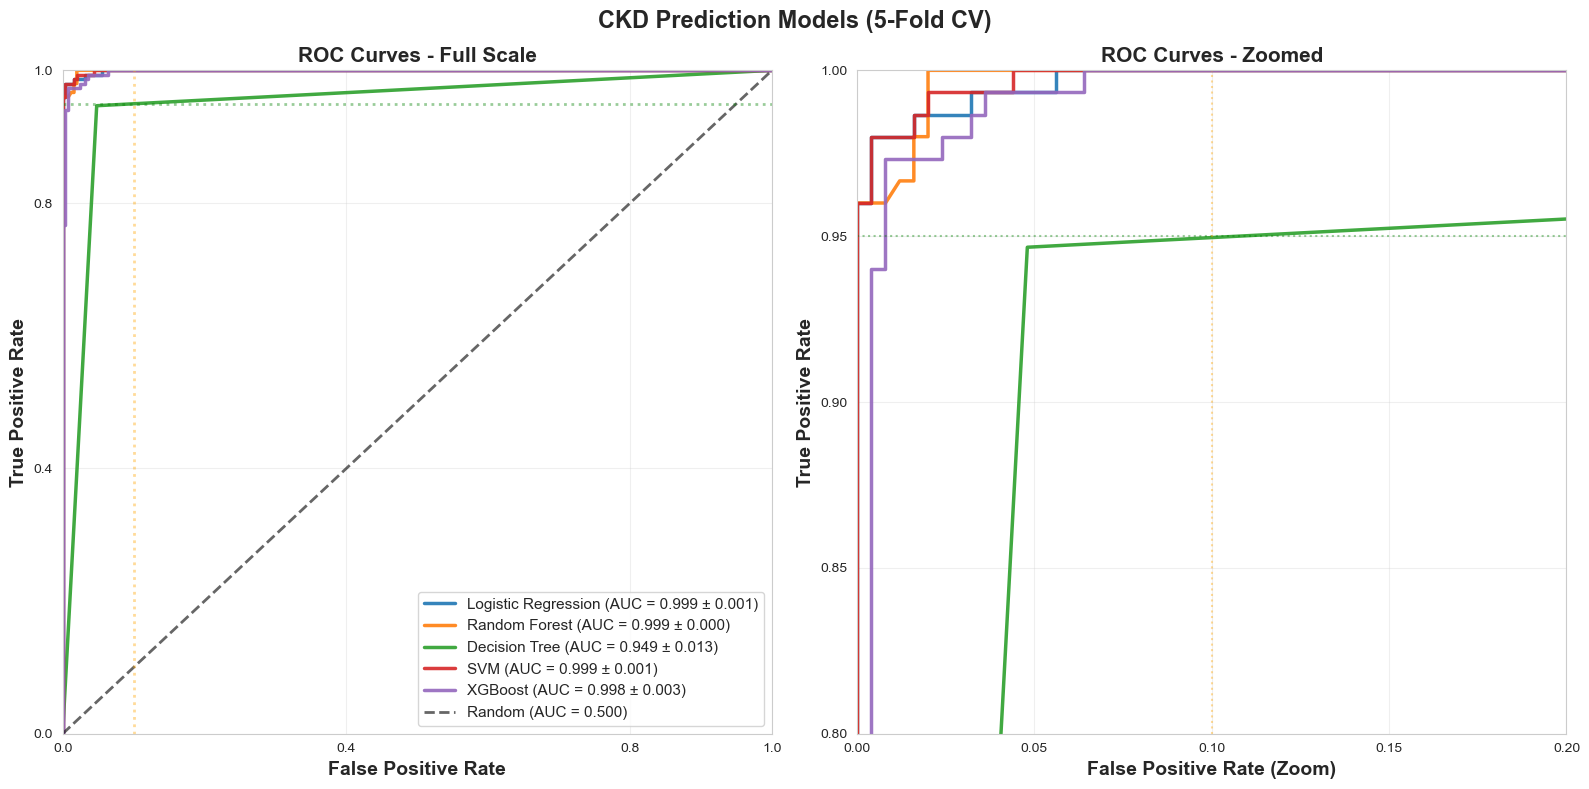

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve, auc

colors = {
    'Logistic Regression': '#1f77b4',
    'Random Forest': '#ff7f0e',
    'Decision Tree': '#2ca02c',
    'SVM': '#d62728',
    'XGBoost': '#9467bd'
}

# Compute ROC curves for each model
roc_data = {}
for model_name, pipeline in models.items():
    y_proba = cross_val_predict(pipeline, X, y, cv=skf, method='predict_proba', n_jobs=-1)
    fpr, tpr, _ = roc_curve(y, y_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    
    roc_data[model_name] = {
        'fpr': fpr,
        'tpr': tpr,
        'auc': roc_auc,
        'std_auc': results[model_name]['roc_auc_std']
    }

# Create side-by-side plots
fig, (ax_full, ax_zoom) = plt.subplots(1, 2, figsize=(16, 8))

for model_name, data in roc_data.items():
    ax_full.plot(
        data['fpr'], data['tpr'],
        color=colors[model_name],
        label=f"{model_name} (AUC = {data['auc']:.3f} ± {data['std_auc']:.3f})",
        linewidth=2.5, alpha=0.9
    )
    ax_zoom.plot(
        data['fpr'], data['tpr'],
        color=colors[model_name],
        linewidth=2.5, alpha=0.9
    )

# Reference lines
ax_full.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random (AUC = 0.500)', alpha=0.6)
ax_zoom.plot([0, 0.2], [0, 0.2], 'k--', linewidth=1.5, alpha=0.5)

ax_full.axhline(y=0.95, color='green', linestyle=':', linewidth=2, alpha=0.4)
ax_full.axvline(x=0.10, color='orange', linestyle=':', linewidth=2, alpha=0.4)
ax_zoom.axhline(y=0.95, color='green', linestyle=':', linewidth=1.5, alpha=0.4)
ax_zoom.axvline(x=0.10, color='orange', linestyle=':', linewidth=1.5, alpha=0.4)

# Format full-scale plot
ax_full.set_xlim([0.0, 1.0])
ax_full.set_ylim([0.0, 1.0])
tick_positions = np.append(np.arange(0, 1.0, 0.4), 1.0)
ax_full.set_xticks(tick_positions)
ax_full.set_yticks(tick_positions)
ax_full.set_xlabel('False Positive Rate', fontsize=14, fontweight='bold')
ax_full.set_ylabel('True Positive Rate', fontsize=14, fontweight='bold')
ax_full.set_title('ROC Curves - Full Scale', fontsize=15, fontweight='bold')
ax_full.legend(loc="lower right", fontsize=11)
ax_full.grid(alpha=0.3)

# Format zoomed plot
ax_zoom.set_xlim([0.0, 0.2])
ax_zoom.set_ylim([0.8, 1.0])
ax_zoom.set_xticks([0.0, 0.05, 0.10, 0.15, 0.20])
ax_zoom.set_yticks([0.80, 0.85, 0.90, 0.95, 1.00])
ax_zoom.set_xlabel('False Positive Rate (Zoom)', fontsize=14, fontweight='bold')
ax_zoom.set_ylabel('True Positive Rate', fontsize=14, fontweight='bold')
ax_zoom.set_title('ROC Curves - Zoomed', fontsize=15, fontweight='bold')
ax_zoom.grid(alpha=0.3)

fig.suptitle('CKD Prediction Models (5-Fold CV)', fontsize=17, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

In [ ]:
# Ranking models by clinical priorities (Sensitivity first, then Specificity, then AUC)
comparison_df = pd.DataFrame(results).T

ranking_df = pd.DataFrame({
    'Model': comparison_df.index,
    'Sensitivity': comparison_df['sensitivity_mean'].values,
    'Specificity': comparison_df['specificity_mean'].values,
    'ROC-AUC': comparison_df['roc_auc_mean'].values,
    'Accuracy': comparison_df['accuracy_mean'].values
})

ranking_df = ranking_df.sort_values(
    by=['Sensitivity', 'Specificity', 'ROC-AUC'], 
    ascending=False
).reset_index(drop=True)

ranking_df.index = ranking_df.index + 1
ranking_df.index.name = 'Rank'

print(ranking_df.to_string())

                    Model  Sensitivity  Specificity   ROC-AUC  Accuracy
Rank                                                                   
1     Logistic Regression     0.986667        0.980  0.999200    0.9825
2                     SVM     0.980000        0.984  0.999333    0.9825
3                 XGBoost     0.973333        0.988  0.997600    0.9825
4           Random Forest     0.960000        0.992  0.999467    0.9800
5           Decision Tree     0.946667        0.952  0.949333    0.9500


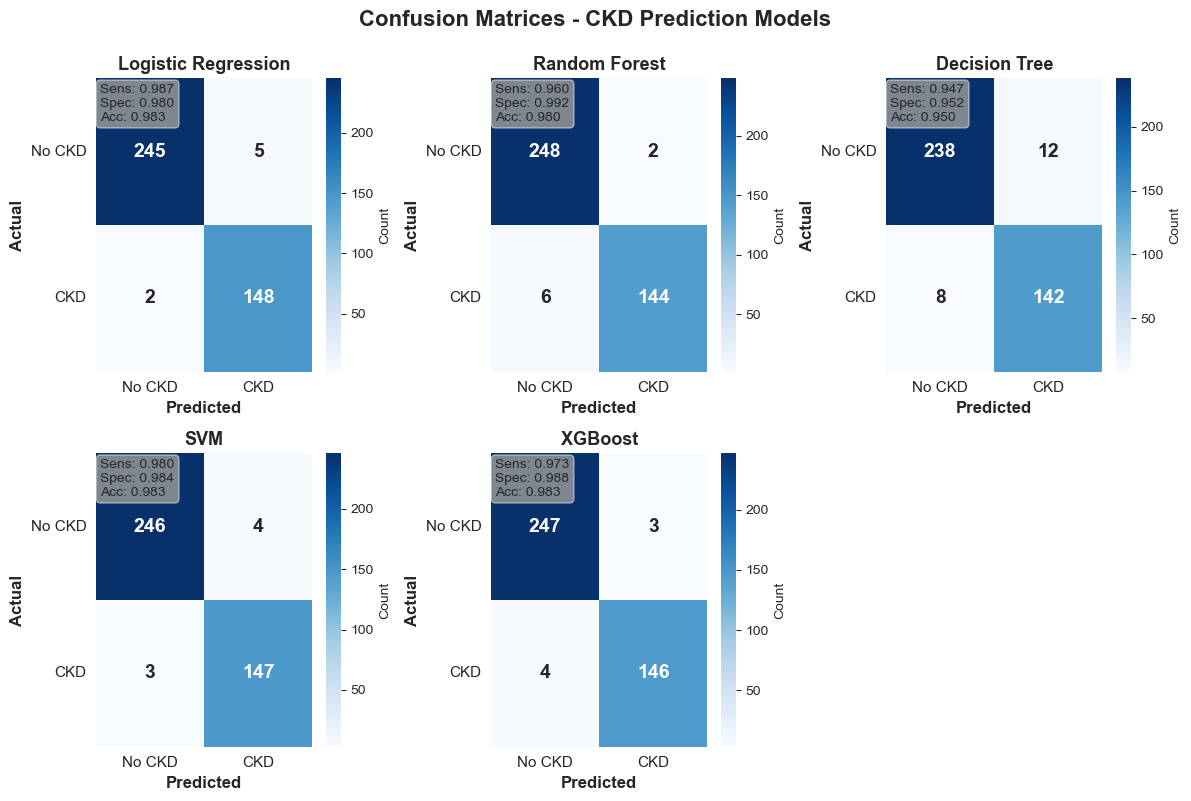

In [ ]:
from sklearn.metrics import confusion_matrix

# Create confusion matrices for all models
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.ravel()

for idx, (model_name, pipeline) in enumerate(models.items()):
    y_pred = cross_val_predict(pipeline, X, y, cv=skf, n_jobs=-1)
    cm = confusion_matrix(y, y_pred)
    
    ax = axes[idx]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, 
                cbar_kws={'label': 'Count'}, 
                annot_kws={'size': 14, 'weight': 'bold'})
    
    ax.set_xlabel('Predicted', fontsize=12, fontweight='bold')
    ax.set_ylabel('Actual', fontsize=12, fontweight='bold')
    ax.set_title(f'{model_name}', fontsize=13, fontweight='bold')
    ax.set_xticklabels(['No CKD', 'CKD'], fontsize=11)
    ax.set_yticklabels(['No CKD', 'CKD'], fontsize=11, rotation=0)
    
    # Calculate and display metrics
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    metrics_text = f'Sens: {sensitivity:.3f}\nSpec: {specificity:.3f}\nAcc: {accuracy:.3f}'
    ax.text(0.02, 0.98, metrics_text, transform=ax.transAxes, 
            fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

axes[5].axis('off')

fig.suptitle('Confusion Matrices - All Models', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

In [ ]:
# Save results for later reference
import os
results_dir = '/Users/reembaraka/Documents/Boulder data science/DTSA 5506/Project/results'
os.makedirs(results_dir, exist_ok=True)

comparison_df = pd.DataFrame(results).T
comparison_df.to_csv(f'{results_dir}/model_comp_results.csv')
ranking_df.to_csv(f'{results_dir}/model_ranking.csv')

print("Results saved!")